In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Stage : plans PIV
"""
DataFolder="C:/Users/Julie_000/Desktop/Stage" 

# I-Champs bidimensionnels de vitesse by Clément

In [25]:
# Importation des librairies
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par dÃ©faut des figures qu'on trace
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import sys
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver

import scipy as sc #pour l'analyse
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import MaxNLocator #pour le contour

## I-1) Définition des fonctions

In [26]:
# Definition des fonctions
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def donnees(prof,plan,manips):
    """Retourne les tableaux de données pour le plan choisi de la profondeur donnée"""
    
    piv=PIV(prof,manips)
    u=np.array(piv[plan]['u'])
    v=np.array(piv[plan]['v'])
    x=np.array(piv[plan]['x'])
    y=np.array(piv[plan]['y'])
    return(u,v,x,y)

## I-2) Chargement des données

In [27]:
# Chargement des données:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
plan=2
    
u,v,x,y=donnees(prof, plan, manips)

## I-3) Plot du champ de vitesse d'un plan choisi pour une profondeur donnée

<IPython.core.display.Javascript object>


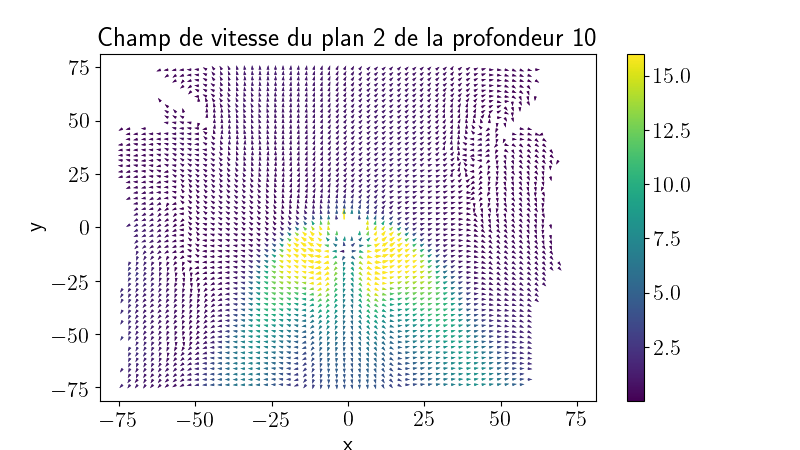

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [28]:
#%matplotlib notebook
"Tracé du champ de vitesse pour la profondeur et le plan choisi"

## Pour mieux les représenter, Clément bidouille la colormap
velocity=np.sqrt(u**2+v**2)
velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = velocity
colors[velocity>velmax]=velmax
colormap=cm.viridis#colormap
norm = Normalize()
norm.autoscale(colors)
    
##plot    
plt.subplots() #pour pas que le plot soit remplacé à chaque fois
cb=plt.colorbar(plt.quiver(x,y,u/velocity,v/velocity,colors)) #pour la barre de couleur
plt.title("Champ de vitesse du plan {} de la profondeur {}".format(plan,prof))
plt.xlabel("x")
plt.ylabel("y")
plt.quiver(x,y,u/velocity,v/velocity,colors)#quiver pour plotter des champs de vecteurs

# II- Calcul de la divergence bidimensionnelle

## II-1) Approche naïve : différencier sans lisser

### II-1-1) Définition des fonctions


In [29]:
#Définition des fonctions

def deriv(y,x,axis):
    """Dérive un tableau 2D y par rapport à x suivant un axe donné"""
    if axis==0:
        return((y[1:,:]-y[:-1,:])/(x[1:,:]-x[:-1,:]))#Donc là le tableau est de taille (n-1,n)
    if axis==1:
        return((y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1]))#Donc là le tableau est de taille (n,n-1)
    return("deriv ne fonctionne que pour des tableaux 2D")
    

def abcisse(x,axis):
    """somme discrète x[i+1]+x[i]/2 suivant un axe donné"""
    if axis==0:
        return((x[1:,:]+x[:-1,:])/2)
    if axis==1:
        return((x[:,1:]+x[:,:-1])/2)
    return("deriv ne fonctionne que pour des tableaux 2D")
        
    
def good_shape(a,b,n):
    "remise à la bonne shape des tableaux a et b pour pouvoir ensuite les sommer"
    "Ne fonctionne que dans ce cas précis avec des tableaux (n,n-1) et (n-1,n) et donne un tableau (n-1,n-1)"
    #donc on perd des données, je ne sais pas comment faire autrement...
    if np.shape(a)[0]==n:
        return(a[:-1,:],b[:,:-1])
    if np.shape(a)[1]==n:
        return(a[:,:-1],b[:-1,:])
    return("les dimensions des array ne conviennent pas pour l'usage de good_shape, ou problème avec n")
 
    
def divergence2D(a,b):
    "juste somme d'array"
    if np.shape(a)==np.shape(b):
        return(a+b)
    return("les array n'ont pas la bonne shape")

In [30]:
"Petits tests"
a=np.reshape(np.arange(1,26),(5,5))
b=np.reshape(np.arange(1,76,3),(5,5))
da_0=deriv(a,b,1)
da_1=deriv(a,b,0)
#print(np.shape(da_0),np.shape(da_1))

da_0,da_1=good_shape(da_0,da_1,5)

print(np.shape(da_0),np.shape(da_1))

(4, 4) (4, 4)


### II-1-2) Chargement des tableaux

In [31]:
"Dérivation"
du,dv=deriv(u,x,1),deriv(v,y,0)
dx,dy=abcisse(x,1),abcisse(y,0)

"Remise à la bonne taille"
du,dv=good_shape(du,dv,60)
dx,dy=good_shape(dx,dy,60)

"somme des tableaux"
div = divergence2D(du,dv)
print(np.shape(dx))
print(np.max(div),np.min(div),np.mean(div),np.std(div))

(59, 59)
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878


### II-1-3) Premier plot

<IPython.core.display.Javascript object>


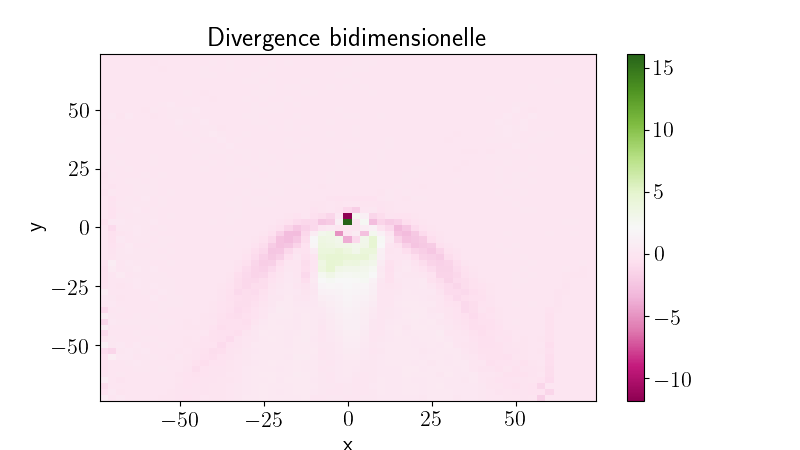

In [34]:
%matplotlib notebook
colors_div = div
colormap2=cm.PiYG#colormap

    
#plot 
fig,ax=plt.subplots(nrows=1)
im=ax.pcolormesh(x,y,div,cmap=colormap2)
ax.set_title("Divergence bidimensionelle")
fig.colorbar(im, ax=ax)
plt.xlabel("x")
plt.ylabel("y")

plt.show()


"`piste qui ne donne rien pour l'instant`"
#bidouillage
divmax=np.mean(div)+np.std(div)#norme maximale représentée sur la colormap borne sup arbitraire
colors_div[div>divmax]=divmax

#plot
plt.subplots()
plt.title("Divergence bidimensionelle2")
plt.xlabel("x")
plt.ylabel("y")
plt.pcolormesh(x,y,div,cmap=colormap,norm=norm)
plt.show()


### II-1-4) Représentation et affinage
#### a-Superposition du nageur

Ici le but est d'enlever les données qui ne correspondent à rien sous le nageur. On enlève donc une zone de 5x5mm^2 soit donc 12x12 pixels centrée en 0. Je remplace cette zone par des 0, ce qui devrait apparaître blanc et correspond à peu près à la moyenne

In [10]:
#definition des fonctions

def masque(a):
    "Enlève les données sous le nageur"
    a[27:33,27:33]=np.zeros((6,6))
    return(a)

div_masque=masque(div)
print(np.max(div_masque),np.min(div_masque),np.mean(div_masque),np.std(div_masque))

4.826524900595196 -3.217848651968189 0.00683726656630734 0.5795074540474114


<IPython.core.display.Javascript object>


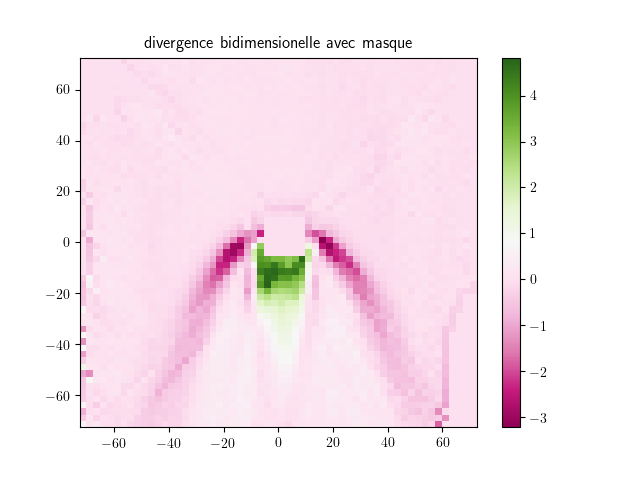

In [18]:
%matplotlib notebook
#plot

fig, ax = plt.subplots(nrows=1)
im = ax.pcolormesh(dx, dy, div_masque, cmap=colormap2)
fig.colorbar(im, ax=ax)
ax.set_title('divergence bidimensionelle avec masque')
plt.show()

C'est pas mal !

#### b-Courbes de niveau

<IPython.core.display.Javascript object>


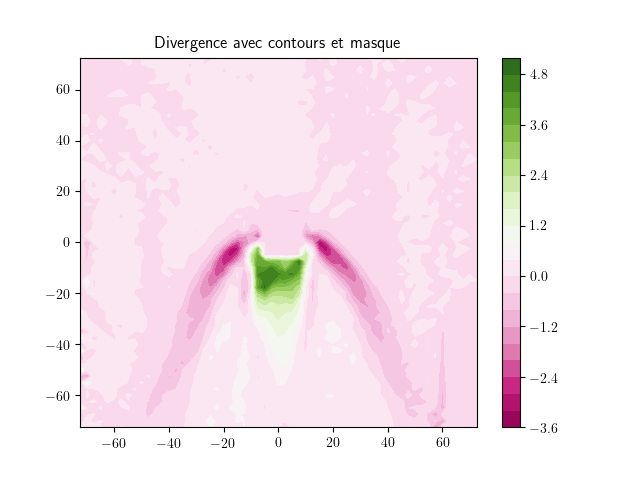

In [19]:
"A améliorer"
fig, ax = plt.subplots(nrows=1)

#résolution :
levels = MaxNLocator(nbins=25).tick_values(div.min(), div.max())



# contours are *point* based plots, so convert our bound into point centers
cf = ax.contourf(dx,dy,div_masque,levels=levels, cmap=colormap2)
fig.colorbar(cf, ax=ax)
ax.set_title('Divergence avec contours et masque')

plt.show()

#### c-Ajout gradient

In [13]:
#définition des fonctions

grad_div_y, grad_div_x=np.gradient(div)
print(np.shape(grad_div_x),np.shape(grad_div_y))

(59, 59) (59, 59)


<IPython.core.display.Javascript object>


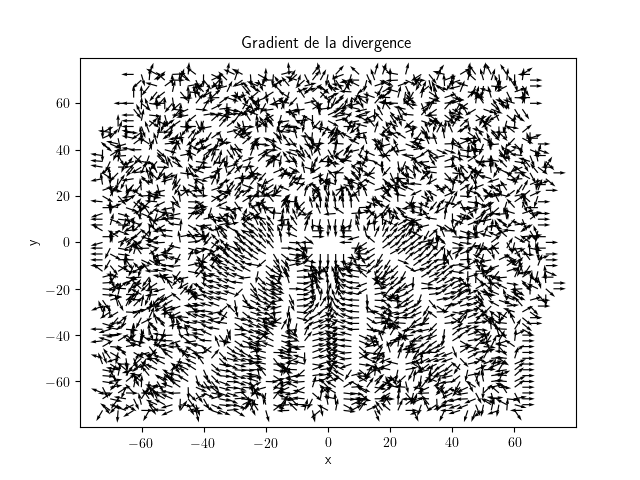

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [21]:
#plot
%matplotlib notebook   

cmap3=cm.magma

norme=np.sqrt(grad_div_y**2+ grad_div_x**2)
#norm = Normalize()
#norm.autoscale(norme)

fig, ax = plt.subplots(nrows=1)
im = ax.quiver(dx, dy, grad_div_x/norme,grad_div_y/norme,scale=40)


plt.xlabel("x")
plt.ylabel("y")
ax.set_title('Gradient de la divergence')
plt.show()



<IPython.core.display.Javascript object>


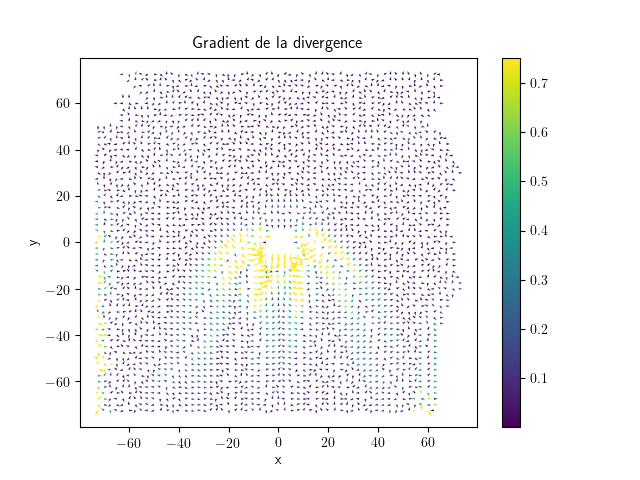

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [15]:
#test gradient tout seul
%matplotlib notebook   
colormap4=cm.magma#colormap
grad_norme=np.sqrt(grad_div_y**2+ grad_div_x**2)
gradmax=np.mean(grad_norme)+2*np.std(grad_norme)#norme maximale représentée sur la colormap borne sup arbitraire
echelle = grad_norme
echelle[grad_norme>gradmax]=gradmax



fig, ax = plt.subplots(nrows=1)
im = ax.quiver(dx, dy, grad_div_x/grad_norme,grad_div_y/grad_norme,echelle)
fig.colorbar(im, ax=ax)
plt.xlabel("x")
plt.ylabel("y")
ax.set_title('Gradient de la divergence')
plt.show()

Superposition des deux graphs : (il va falloir améliorer les tailles des flèches)

<IPython.core.display.Javascript object>


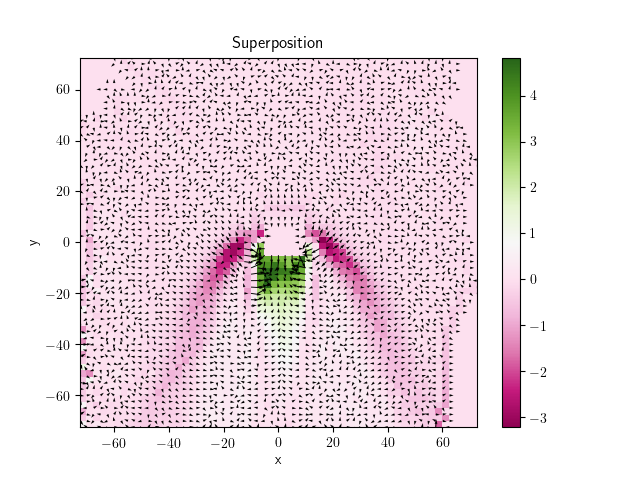

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [16]:
fig,ax=plt.subplots(nrows=1)
im2=plt.pcolormesh(dx, dy, div_masque, cmap=colormap2)
plt.colorbar(im2)
im = ax.quiver(dx, dy, grad_div_x/grad_norme,grad_div_y/grad_norme,scale=95)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Superposition')
plt.show()

## Filtre gaussien
### Application du filtre sur la divergence